<a href="https://colab.research.google.com/github/ykato27/Auto-Encorder/blob/main/anomaly_detection_autoencoder_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#anomaly detection using autoencoder:pytorch

https://benjoe.medium.com/anomaly-detection-using-pytorch-autoencoder-and-mnist-31c5c2186329

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
!mkdir data

#mnist datasetのアップロード

以下のサイトからmnist-in-csv ファイルをPCにダウンロードしてください

https://www.kaggle.com/oddrationale/mnist-in-csv/download


In [3]:
from google.colab import files

uploaded = files.upload()

Saving mnist.zip to mnist.zip


In [4]:
!unzip mnist.zip -d data
!ls data/

Archive:  mnist.zip
  inflating: data/mnist_test.csv     
  inflating: data/mnist_train.csv    
mnist_test.csv	mnist_train.csv


In [5]:
df = pd.read_csv("data/mnist_test.csv")

In [6]:
anom = df[:1000]
clean = df[1000:]

In [7]:
for i in range(len(anom)):
    # select row from anom
    row = anom.iloc[i]
    # iterate through each element in row
    for i in range(len(row) - 1):
        # add noise to element
        row[i + 1] = min(255, row[i + 1] + random.randint(100, 200))

In [8]:
anom["label"] = 1
clean["label"] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
an_test = pd.concat([anom, clean])  # join
an_test.sample(frac=1)  # shuffle
an_test.to_csv("anom.csv")  # save

##Autoencoder

An autoencoder is comprised of two systems: an encoder and a decoder.

For our purposes the following architecture was used as a simple linear compression from input to latent representation.


In [10]:
import torch.nn as nn


class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.enc = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
        )
        self.dec = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.ReLU(),
        )

    def forward(self, x):
        encode = self.enc(x)
        decode = self.dec(encode)
        return decode

In [11]:
import random
import time
from collections import defaultdict
from datetime import timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

In [12]:
batch_size = 32
lr = 1e-2  # learning rate
w_d = 1e-5  # weight decay
momentum = 0.9
epochs = 15

In [13]:
class Loader(torch.utils.data.Dataset):
    def __init__(self):
        super(Loader, self).__init__()
        self.dataset = ""

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        row = self.dataset.iloc[idx]
        row = row.drop(labels={"label"})
        data = torch.from_numpy(np.array(row) / 255).float()
        return data


class Train_Loader(Loader):
    def __init__(self):
        super(Train_Loader, self).__init__()
        self.dataset = pd.read_csv("data/mnist_train.csv", index_col=False)

In [14]:
train_set = Train_Loader()
train_ = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True,
)

In [15]:
metrics = defaultdict(list)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = AE()
model.to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=w_d)

In [16]:
model.train()
start = time.time()
for epoch in range(epochs):
    ep_start = time.time()
    running_loss = 0.0
    for bx, (data) in enumerate(train_):
        sample = model(data.to(device))
        loss = criterion(data.to(device), sample)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_set)
    metrics["train_loss"].append(epoch_loss)
    ep_end = time.time()
    print("-----------------------------------------------")
    print("[EPOCH] {}/{}\n[LOSS] {}".format(epoch + 1, epochs, epoch_loss))
    print("Epoch Complete in {}".format(timedelta(seconds=ep_end - ep_start)))
end = time.time()
print("-----------------------------------------------")
print("[System Complete: {}]".format(timedelta(seconds=end - start)))

-----------------------------------------------
[EPOCH] 1/15
[LOSS] 0.00335891513650616
Epoch Complete in 0:00:38.218056
-----------------------------------------------
[EPOCH] 2/15
[LOSS] 0.003255509746943911
Epoch Complete in 0:00:36.431253
-----------------------------------------------
[EPOCH] 3/15
[LOSS] 0.0031505433196822802
Epoch Complete in 0:00:38.335790
-----------------------------------------------
[EPOCH] 4/15
[LOSS] 0.0030367340161154667
Epoch Complete in 0:00:37.408088
-----------------------------------------------
[EPOCH] 5/15
[LOSS] 0.0029165050321569045
Epoch Complete in 0:00:37.378619
-----------------------------------------------
[EPOCH] 6/15
[LOSS] 0.002802825160572926
Epoch Complete in 0:00:36.935323
-----------------------------------------------
[EPOCH] 7/15
[LOSS] 0.0027162184114257497
Epoch Complete in 0:00:37.633105
-----------------------------------------------
[EPOCH] 8/15
[LOSS] 0.002670234120016297
Epoch Complete in 0:00:36.461609
---------------------

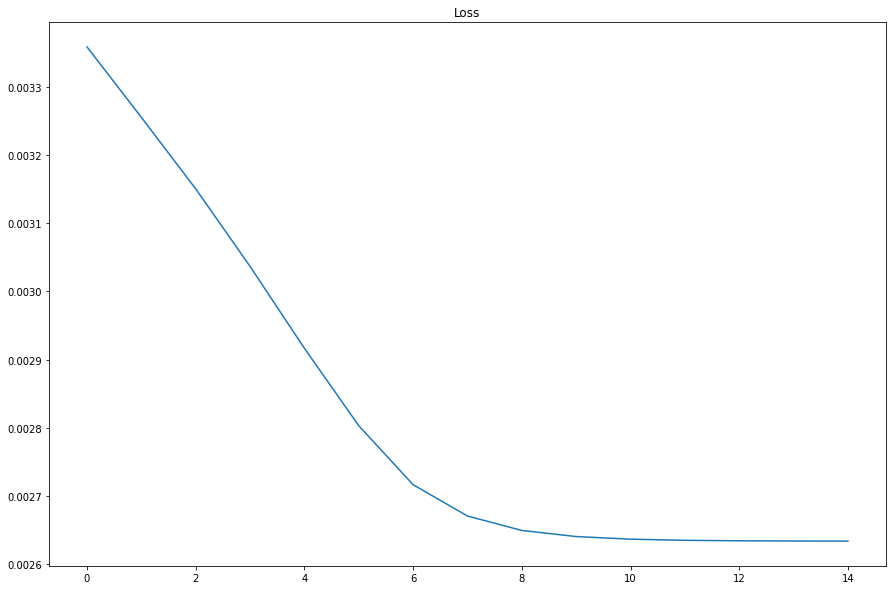

In [17]:
_, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.set_title("Loss")
ax.plot(metrics["train_loss"])

In [18]:
model.eval()
loss_dist = []
anom = pd.read_csv("anom.csv", index_col=[0])
# for bx, data in enumerate(test_):
for i in range(len(anom)):
    data = torch.from_numpy(np.array(anom.iloc[i][1:]) / 255).float()
    sample = model(data.to(device))
    loss = criterion(data.to(device), sample)
    loss_dist.append(loss.item())

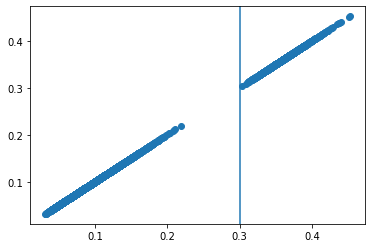

In [19]:
loss_sc = []
for i in loss_dist:
    loss_sc.append((i, i))
plt.scatter(*zip(*loss_sc))
plt.axvline(0.3, 0.0, 1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


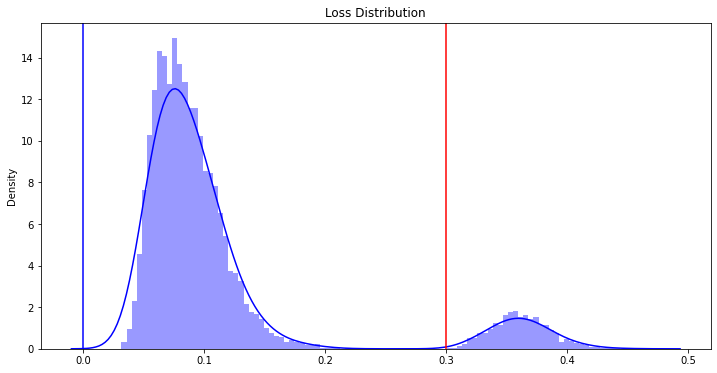

In [20]:
lower_threshold = 0.0
upper_threshold = 0.3
plt.figure(figsize=(12, 6))
plt.title("Loss Distribution")
sns.distplot(loss_dist, bins=100, kde=True, color="blue")
plt.axvline(upper_threshold, 0.0, 10, color="r")
plt.axvline(lower_threshold, 0.0, 10, color="b")

In [21]:
df = pd.read_csv("anom.csv", index_col=[0])
ddf = pd.DataFrame(columns=df.columns)
tp = 0
fp = 0
tn = 0
fn = 0
total_anom = 0
for i in range(len(loss_dist)):
    total_anom += df.iloc[i]["label"]
    if loss_dist[i] >= upper_threshold:
        n_df = pd.DataFrame([df.iloc[i]])
        n_df["loss"] = loss_dist[i]
        ddf = pd.concat([df, n_df], sort=True)
        if float(df.iloc[i]["label"]) == 1.0:
            tp += 1
        else:
            fp += 1
    else:
        if float(df.iloc[i]["label"]) == 1.0:
            fn += 1
        else:
            tn += 1
print("[TP] {}\t[FP] {}\t[MISSED] {}".format(tp, fp, total_anom - tp))
print("[TN] {}\t[FN] {}".format(tn, fn))

[TP] 1000	[FP] 0	[MISSED] 0
[TN] 9000	[FN] 0


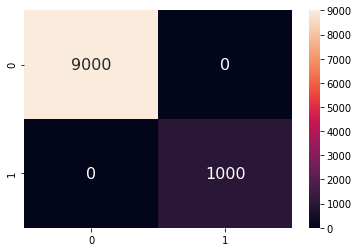

In [22]:
conf = [[tn, fp], [fn, tp]]
plt.figure()
sns.heatmap(conf, annot=True, annot_kws={"size": 16}, fmt="g")